# A. Anomaly Detection: Overview, Motivation, and Simple Model

Goal of this workbook

1. Know univariate gaussian method to detect
2. Be able to do simple detection
3

In [1]:
# Data Processing
import numpy as np 
import pandas as pd
import scipy as sp
from functools import reduce

# Dim Reduction
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#get inline plots
%matplotlib inline 


### General Idea: 

An anomaly is...

Anomaly Detection using Statistical Methods
There's a distribution that belongs to inliers. 
Anomalies are not well modeled by the distribution.

Requirements:
- Data looks normal
    - If it's not, try transforming it.
- Little to no correlation.  Covariance matrix looks like:


What happens when we change our covariance matrix?

In [2]:
print(np.array([[1,0],[0,1]]))

[[1 0]
 [0 1]]


In [3]:
def gen_outlier(n):
    whole = np.random.uniform(3,4, n)
    negative = np.random.uniform(0,1,n) < .5
    values = np.multiply(negative*(-2)+1,whole)
    return  values

def gen_outlier_frame(n,m):
    col_names = ['feature_' + str(i) for i in np.arange(1,m+1)]
    frame_out = pd.DataFrame(
        [list(gen_outlier(i)) for i in n*[m]], 
    columns = col_names)
    return frame_out

def gen_inlier_frame(n,m):
    col_names = ['feature_' + str(i) for i in np.arange(1,m+1)]
    frame_out = pd.DataFrame(np.random.normal(0,1, size = (n,m)), columns=col_names)
    return frame_out

def normalize(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    return (x - mu)/sigma

def ad_plot(x, y, mask):
    plt.figure(figsize=(16,8))
    sns.kdeplot(x, y)
    sns.regplot(x=x[~mask], y=y[~mask], fit_reg=False,color='g',scatter_kws={'alpha':0.25})
    sns.regplot(x=x[mask], y=y[mask],fit_reg=False,color='red')
    
    
def estimate_gaussian(x):
    # Step 1: Normalize
    x = normalize(x)
    # Step 2: Use sp.stats.norm.pdf on results above
    x = x.apply(lambda v: sp.stats.norm.pdf(v),1)
    # Step 3: get Probabilities of Feature_1 x Features_2 x .... Feature_n
    return x.apply(np.prod,1)


## Generate Data

In [4]:
n_features = 5
outlier_n = 10
inlier_n = 1000

In [18]:
outlier = gen_outlier_frame(outlier_n,n_features)
inlier = gen_inlier_frame(inlier_n,n_features)
inlier['label'] = 'inlier'
outlier['label'] = 'outlier'
df = outlier.append(inlier)
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,label
0,-3.816530,3.825425,-3.169435,-3.266080,3.210792,outlier
1,-3.896725,-3.407617,3.198228,3.790952,-3.748214,outlier
2,3.276750,-3.881513,3.945871,-3.422077,-3.543293,outlier
3,3.376768,-3.118256,3.391674,-3.361903,-3.836203,outlier
4,3.269782,3.737697,3.260996,-3.738168,3.249385,outlier


## Plot Densities
- Plot Inlier Kernal Density Plot - Green
- Plot Inlier Kernal Density Plot - Red

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


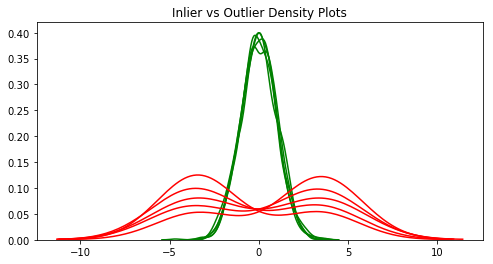

In [33]:
# you try, plot below all density curves
plt.figure(figsize=(8,4))
_ = inlier.drop('label',1).apply(lambda x: sns.kdeplot(x, color='green', legend = False), 0)
_ = outlier.drop('label',1).apply(lambda x: sns.kdeplot(x, color = 'red', legend = False), 0)
_ = plt.title('Inlier vs Outlier Density Plots')

## Get Probabilities
1. Create zscore for each column
2. Get Probabilities for each column
3. Get Joint Probabilities by multiplying P(Feature 1) * P(Feature 2) * P(Feature 3)
    - Note, this assumes independence assumption

In [35]:
# you try:
df_raw = df

# Step 1: normalize:
df_normed = normalize(df.drop(['label'],1))

# Step 2: Use sp.stats.norm.pdf on results above
df_p = df_normed.apply(lambda x: sp.stats.norm.pdf(x),1)

# Step 3: get Probabilities of Feature_1 x Features_2 x .... Feature_n
df_raw['prob'] = round(df_p.apply(np.prod,1)*100,100)


,feature_1,feature_2,feature_3,feature_4,feature_5,label,prob
0,-3.816530,3.825425,-3.169435,-3.266080,3.210792,outlier,4.104467e-13
1,-3.896725,-3.407617,3.198228,3.790952,-3.748214,outlier,1.972321e-14
2,3.276750,-3.881513,3.945871,-3.422077,-3.543293,outlier,1.530671e-14
3,3.376768,-3.118256,3.391674,-3.361903,-3.836203,outlier,3.959352e-13
4,3.269782,3.737697,3.260996,-3.738168,3.249385,outlier,3.242858e-13
5,3.516239,3.509970,3.778904,-3.166805,3.295937,outlier,3.101234e-13
6,3.164558,3.675488,-3.289739,3.186876,3.587270,outlier,1.701071e-12
7,-3.904876,3.179970,-3.848516,-3.748540,-3.947737,outlier,4.237613e-15
8,-3.263640,3.090060,-3.805349,-3.472251,-3.290388,outlier,1.124505e-12
9,3.566466,3.601516,-3.552536,3.177104,-3.380057,outlier,5.076947e-13


## Selecting a Threshold
Because we have our data set labeled, we can identify an epsilon (threshold, aka "outlier fraction") using descriptive stats.


In [36]:
## Your Turn:
df = df_raw

# Create a a pivot table showing the min and max probabilities with index = label. Columns need to show "min" and "max"
# values should display min and max of "prob" column.

df.pivot_table(
    index = 'label',
    aggfunc=[np.min, np.max],
    values = 'prob').apply(
    lambda x: np.round(x, decimals = 8))

,amin,amax
label,,
inlier,0.000003,0.116161
outlier,0.000000,0.000000


In [37]:
epsilon = df[df.label == 'outlier'].prob.max()
mask =  [i<=epsilon for i in df_raw.prob]

df_raw['pred'] = ['outlier' if i <= epsilon else 'inlier' for i in df_raw.prob]

## Visualizing Outliers in 2D

Let's take a look at how our detection played out. First do a scatter plot of some features. Plot markers with outliers showing up as red and outliers showing up as green.

Set your features > 2 and use PCA with n_components = 2. Plot component 1 and 2 along X and Y axes. Color the markers the same way. 

**Hint**: You're doing two graphs.

**bonus**: make a kdeplotto show bivariate kernel density estimation

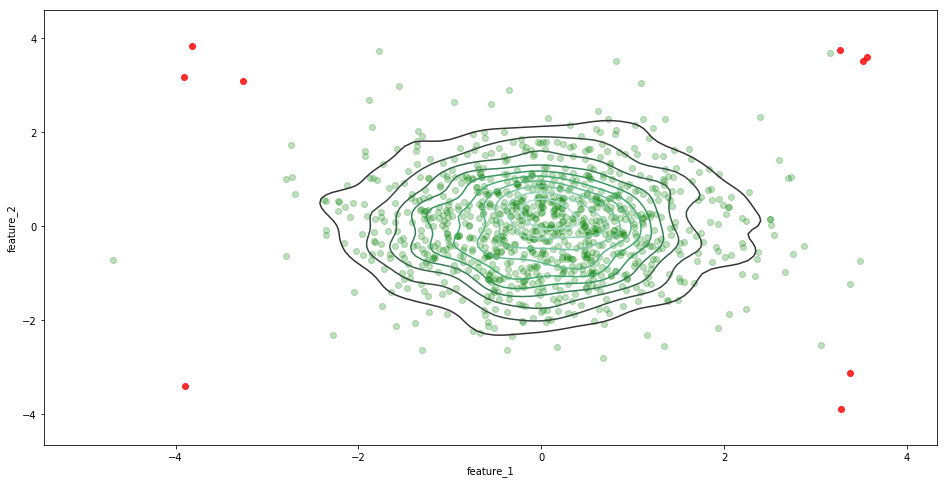

In [38]:
ad_plot(x = df_raw.feature_1, y = df_raw.feature_2 , mask = df_raw.prob < epsilon )

### Reduce dimensions to two using PCA

In [39]:
# your turn here:
two_dim = PCA(n_components= 2)
two_dim.fit(df_raw.drop(['prob','label','pred'],1).T)
two_dim_frame = pd.DataFrame(two_dim.components_.T, columns= ['PCA1','PCA2'])
two_dim_frame['pred'] = df_raw.pred.reset_index(drop = True)

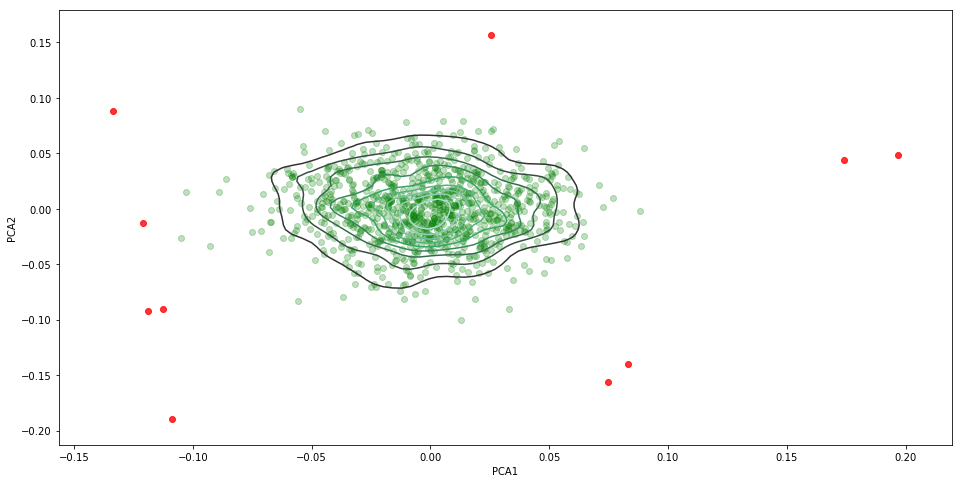

In [40]:
ad_plot(x = two_dim_frame.PCA1, y = two_dim_frame.PCA2 , mask = two_dim_frame.pred == 'outlier')

#### BONUS!!

Do a confusion matrix that shows true / false positives / negatives. 

In [41]:
confusion_matrix(y_true = df_raw.label, y_pred = df_raw.pred)

array([[1000,    0],
       [   0,   10]])